In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm as mm
from simtk import unit
from openmmtools.testsystems import LennardJonesFluid
from uibcdf_test_systems.simulation import langevin_NVT
from tqdm import tqdm

Torrie, G. M., & Valleau, J. P. (1977). Nonphysical sampling distributions in Monte Carlo free-energy estimation: Umbrella sampling. Journal of Computational Physics, 23(2), 187–199.
doi:10.1016/0021-9991(77)90121-8 

## Lennard-Jones Potential

In [3]:
def LJ_potential(distance, sigma, epsilon):
    q=sigma/distance
    q6=q**6
    q12=q6**2
    return 4.0*epsilon*(q12-q6)

In [4]:
sigma = 3.4*unit.angstrom
epsilon = 0.238 * unit.kilocalories_per_mole

In [5]:
dd = np.linspace(0.001,3.0, 200, endpoint=True)*sigma

(-1.0, 4.0)

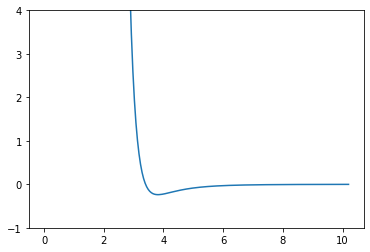

In [6]:
plt.plot(dd,LJ_potential(dd, sigma, epsilon))
plt.ylim(-1.0,4.0)

In [46]:
# number particles larger than the system in the paper
LJfluid = LennardJonesFluid(nparticles=216, sigma=sigma, epsilon=epsilon, reduced_density=0.2) #reduced_density=0.85

Periodic box and cut-off:

In [47]:
LJfluid.system.getDefaultPeriodicBoxVectors()

[Quantity(value=Vec3(x=3.4883509312204612, y=0.0, z=0.0), unit=nanometer),
 Quantity(value=Vec3(x=0.0, y=3.4883509312204612, z=0.0), unit=nanometer),
 Quantity(value=Vec3(x=0.0, y=0.0, z=3.4883509312204612), unit=nanometer)]

In [48]:
ff=LJfluid.system.getForces()
ff[0].getCutoffDistance() # 3 x sigma

Quantity(value=1.02, unit=nanometer)

Critical temperature:

In [49]:
kBTc = 2.74*epsilon
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
Tc = (kBTc/kB).in_units_of(unit.kelvin)
print('Temperature {}'.format(Tc))

Temperature 328.15913329971914 K


In [11]:
collision_rate = 5/unit.picoseconds
timestep = 2.5*unit.femtoseconds

### Simulation

In [50]:
# Thermodinamic state
T = 300.0*unit.kelvin

## Energy Minimization

# Integrator
collision_rate = 5/unit.picoseconds
timestep = 2.5*unit.femtoseconds
integrator = mm.LangevinIntegrator(T, collision_rate, timestep)

# Create a context
context = mm.Context(LJfluid.system, integrator)
context.setPositions(LJfluid.positions)

# Minimize energy
print('Minimizing energy...')
mm.LocalEnergyMinimizer.minimize(context)

Minimizing energy...


In [51]:
state = context.getState(getPositions=True)

In [52]:
initial_positions = state.getPositions()

## Simulation

In [53]:
time, _, _, _, potential_energy = langevin_NVT(LJfluid.system, temperature=300*unit.kelvin, friction=5/unit.picoseconds,
                                               initial_positions=initial_positions, integration_timestep=2.5*unit.femtoseconds,
                                               saving_timestep=1*unit.picoseconds, total_time=520*unit.picoseconds)

100%|██████████| 519/519 [00:23<00:00, 22.23it/s]


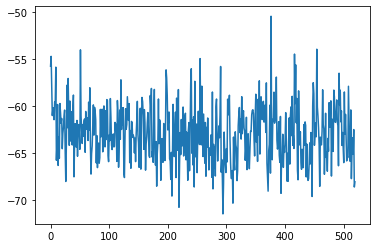

In [54]:
plt.plot(time, potential_energy)
plt.show()

In [55]:
potential_energy[20:].mean()

Quantity(value=-63.049553, unit=kilocalorie/mole)

In [56]:
potential_energy[20:].std()

Quantity(value=2.975062, unit=kilocalorie/mole)

In [57]:
temperatures = np.linspace(100,500,40)*unit.kelvin
n_temperatures = len(temperatures)
mean_potential_energies = np.zeros(n_temperatures)*unit.kilocalorie_per_mole
std_potential_energies = np.zeros(n_temperatures)*unit.kilocalorie_per_mole

for ii in tqdm(range(n_temperatures)):
    T = temperatures[ii]
    _, _, _, _, potential_energy = langevin_NVT(LJfluid.system, temperature=T, friction=5/unit.picoseconds,
                                                initial_positions=initial_positions, integration_timestep=2.5*unit.femtoseconds,
                                                saving_timestep=1*unit.picoseconds, total_time=220*unit.picoseconds, verbose=False)
    mean_potential_energies[ii] = potential_energy[20:].mean()
    std_potential_energies[ii] = potential_energy[20:].std()

100%|██████████| 40/40 [06:10<00:00,  9.26s/it]


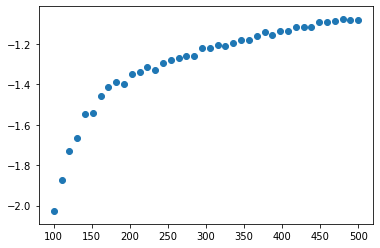

In [58]:
plt.scatter(temperatures, mean_potential_energies/epsilon/216)

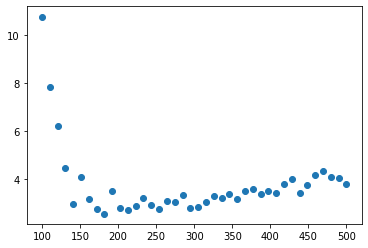

In [59]:
plt.scatter(temperatures, std_potential_energies)

In [ ]:
## ver:
https://github.com/choderalab/openmm7tutorials/tree/master/alchemical-free-energy
http://openmm.org/tutorials/alchemical-free-energy/
https://openmmtools.readthedocs.io/en/latest/api/generated/openmmtools.testsystems.LennardJonesFluid.html
https://openmmtools.readthedocs.io/en/latest/testsystems.html
https://github.com/choderalab/openmmtools/blob/master/openmmtools/testsystems.py
    
